Training on cpu
Epoch [1/50], Train Loss: 0.0250, Test Loss: 0.0194
Epoch [2/50], Train Loss: 0.0016, Test Loss: 0.0033
Epoch [3/50], Train Loss: 0.0005, Test Loss: 0.0045
Epoch [4/50], Train Loss: 0.0004, Test Loss: 0.0037
Epoch [5/50], Train Loss: 0.0005, Test Loss: 0.0045
Epoch [6/50], Train Loss: 0.0004, Test Loss: 0.0040
Epoch [7/50], Train Loss: 0.0004, Test Loss: 0.0052
Epoch [8/50], Train Loss: 0.0004, Test Loss: 0.0031
Epoch [9/50], Train Loss: 0.0004, Test Loss: 0.0035
Epoch [10/50], Train Loss: 0.0004, Test Loss: 0.0041
Epoch [11/50], Train Loss: 0.0004, Test Loss: 0.0027
Epoch [12/50], Train Loss: 0.0004, Test Loss: 0.0045
Epoch [13/50], Train Loss: 0.0004, Test Loss: 0.0036
Epoch [14/50], Train Loss: 0.0004, Test Loss: 0.0047
Epoch [15/50], Train Loss: 0.0004, Test Loss: 0.0033
Epoch [16/50], Train Loss: 0.0005, Test Loss: 0.0042
Epoch [17/50], Train Loss: 0.0004, Test Loss: 0.0031
Epoch [18/50], Train Loss: 0.0003, Test Loss: 0.0034
Epoch [19/50], Train Loss: 0.0004, Test

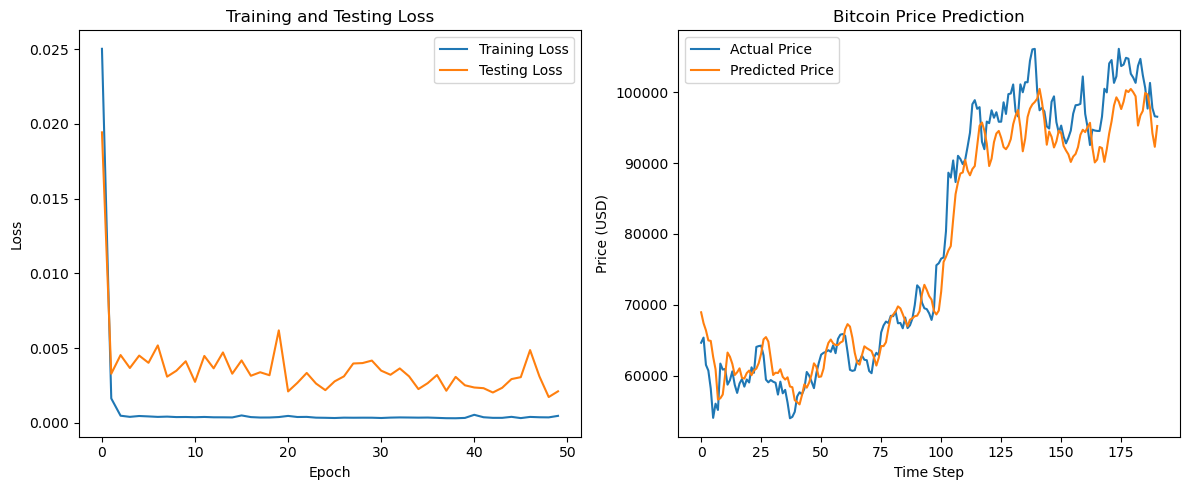

In [3]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# ------------------------
# 1. Data Fetching Function
# ------------------------
def get_historical_data(symbol, interval='1d', start_date=None, end_date=None, limit=1000):
    url = f'https://api.binance.com/api/v3/klines'
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    
    if start_date:
        params['startTime'] = int(pd.Timestamp(start_date).timestamp() * 1000)
    if end_date:
        params['endTime'] = int(pd.Timestamp(end_date).timestamp() * 1000)
    
    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f'Error fetching data: {response.status_code} - {response.text}')
    
    data = response.json()
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df.drop(columns=['ignore'], inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return df

# ------------------------
# 2. Sequence Creation Function
# ------------------------
def create_sequences(X_data, y_data, seq_length):
    xs, ys = [], []
    for i in range(len(X_data) - seq_length):
        xs.append(X_data[i:i+seq_length])
        ys.append(y_data[i+seq_length])
    return np.array(xs), np.array(ys)

# ------------------------
# 3. RNN Model Definition
# ------------------------
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# ------------------------
# 4. Main Training Script
# ------------------------
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
symbol = 'BTCUSDT'
interval = '1d'
start_date = '2022-06-01'
end_date = '2025-02-06'
sequence_length = 30
batch_size = 32

# Fetch and prepare data
df = get_historical_data(symbol, interval, start_date, end_date)
df['target'] = df['close'].shift(-1)
df.dropna(inplace=True)

# Define features
x_cols = ['open', 'high', 'low', 'volume', 
          'quote_asset_volume', 'number_of_trades', 
          'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
y_col = 'target'

# Scale the data
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
df[x_cols] = x_scaler.fit_transform(df[x_cols])
df[[y_col]] = y_scaler.fit_transform(df[[y_col]])

# Create sequences
X_data = df[x_cols].values
y_data = df[y_col].values
X_seq, y_seq = create_sequences(X_data, y_data, sequence_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# Split data
train_size = int(0.8 * len(X_tensor))
X_train = X_tensor[:train_size]
X_test = X_tensor[train_size:]
y_train = y_tensor[:train_size]
y_test = y_tensor[train_size:]

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
input_size = len(x_cols)
hidden_size = 64
output_size = 1
num_layers = 2
learning_rate = 0.001
num_epochs = 50

# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleRNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
test_losses = []
best_test_loss = float('inf')

print(f"Training on {device}")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Testing phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    # Save best model
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(model.state_dict(), 'best_rnn_model.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.cpu().numpy())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Inverse transform predictions and actual values
predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze()
actuals = y_scaler.inverse_transform(actuals.reshape(-1, 1)).squeeze()

# Calculate metrics
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f'\nFinal Metrics:')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

# Plot training and testing loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot predictions vs actual values
plt.subplot(1, 2, 2)
plt.plot(actuals, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()

plt.tight_layout()
plt.show()